## Analyzing maizsim output

Analyzing the first batch of control simulations. <br/>
Simulation outputs stored: /home/disk/eos8/ach315/upscale/sims/con

In [57]:
import numpy as np
import pandas as pd
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import xarray as xr
import datetime

### 1. Figure out where sites are located

In [3]:
site_info = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
site_years = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_years.csv", index_col=0, dtype=str)
df_siteyears = pd.merge(left=site_years, right=site_info, how="inner")
df_siteyears = df_siteyears[df_siteyears.site!='41415'] # exclunding Gwam
df_siteyears.head()

,site,years,city,state,lat,lon
0,03103,21,FLAGSTAFF,AZ,35.08,111.4
1,03812,20,ASHEVILLE,NC,35.26,82.32
2,03813,21,MACON,GA,32.42,83.39
3,03820,19,AUGUSTA,GA,33.22,81.58
4,03822,20,SAVANNAH,GA,32.08,81.12


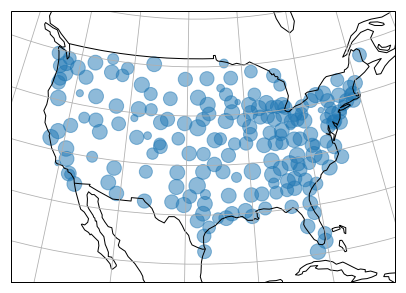

In [4]:
# plotting out sites, and showing years as circle size
extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(8,5))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df_siteyears.lon.astype(float)*-1, df_siteyears.lat.astype(float), 
           transform=ccrs.PlateCarree(), s=df_siteyears.years.astype(float)*10, alpha=0.5)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()
plt.show()

### 2. Load in all simulation outputs

In [330]:
files = glob.glob('/home/disk/eos8/ach315/upscale/sims/con/out1/*')
len(files)

1920

In [331]:
# manual update of maizsim output column name
cols = ['jday', 'time', 'leaves', 'mature_lvs', 'drop_lvs', 'LA', 'LA_dead', 'LAI', 'RH', 
        'leaf_WP', 'PFD', 'solrad', 'temp_soil', 'temp_air', 'temp_can', 'ET_dmd', 'ET_suply',
        'Pn', 'Pg', 'resp', 'av_gs', 'LAI_sunlit', 'LAI_shaded', 'PFD_sunlit', 'PFD_shaded', 
        'An_sunlit', 'An_shaded', 'Ag_sunlit', 'Ag_shaded', 'gs_sunlit', 'gs_shaded', 'VPD',
        'N', 'N_dmd', 'N_upt', 'N_leaf', 'PCRL', 'dm_total', 'dm_shoot', 'dm_ear', 'dm_totleaf', 'dm_dropleaf', 
        'df_stem', 'df_root', 'roil_rt', 'mx_rootdept', 'available_water', 'soluble_c', 'note']

In [332]:
# Fetching max ear biomass value (proxy for yield) from maizsim outputs
# - For some weird reason, quite a few sim outputs don't have headers.
# - I wonder if this has anything to do with the files that I overwrote when moving them into the separate folders.
# - maybe these are runs that got cut off at the 6hrs wall time, and had to be resubmitted so had truncated sim outputs?
# - not sure, haven't checked yet, just a guess

dm_ears = list()
sites = list()
years = list()

for file in files:
    site = file.split('/')[-1].split('_')[-2]
    year = file.split('/')[-1].split('_')[-1].split('.')[-2]
    try:
        df = pd.read_csv(file)
        df.columns = cols
        ear = df.dm_ear.max()
        dm_ears.append(ear)
        sites.append(site)
        years.append(year)
    except:
        print(file)
        df = pd.read_csv(file, header=None, index_col=[0])
        df.columns = cols
        ear = df.dm_ear.max()
        dm_ears.append(ear)
        sites.append(site)
        years.append(year)


/home/disk/eos8/ach315/upscale/sims/con/out1/out1_13958_1983.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_13959_1982.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_14737_1981.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_24233_1979.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_93721_1980.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_94814_1974.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_94822_1975.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_03820_1985.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_03856_1986.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_03860_1984.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_03937_1987.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_14768_1983.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_14820_1982.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_14913_1981.txt
/home/disk/eos8/ach315/upscale/sims/con/out1/out1_94846_1979.txt
/home/disk/eos8/ach315/up

### 3. Create master df that includes lat/lon, year, yield

In [333]:
df_earsum = pd.DataFrame({'ear': dm_ears, 'site': sites, 'year': years})
# there are a few runs that gave extremely high dm_ear values, removing them for now
indexlist = df_earsum[df_earsum.ear > 10000].index 
df_earsum = df_earsum.drop(indexlist)
df_earsum.head()

,ear,site,year
0,53.39,03103,1964
1,87.67,03812,1973
2,99.10,03812,1975
3,97.84,03812,1979
4,51.01,03812,1980


In [334]:
# merging in lat/lon site info
df_earsum = pd.merge(df_earsum, df_siteyears, on='site')
df_earsum.head()

,ear,site,year,years,city,state,lat,lon
0,53.39,03103,1964,21,FLAGSTAFF,AZ,35.08,111.4
1,50.73,03103,1988,21,FLAGSTAFF,AZ,35.08,111.4
2,87.67,03812,1973,20,ASHEVILLE,NC,35.26,82.32
3,99.10,03812,1975,20,ASHEVILLE,NC,35.26,82.32
4,97.84,03812,1979,20,ASHEVILLE,NC,35.26,82.32


### 4. Plotting out yield maps

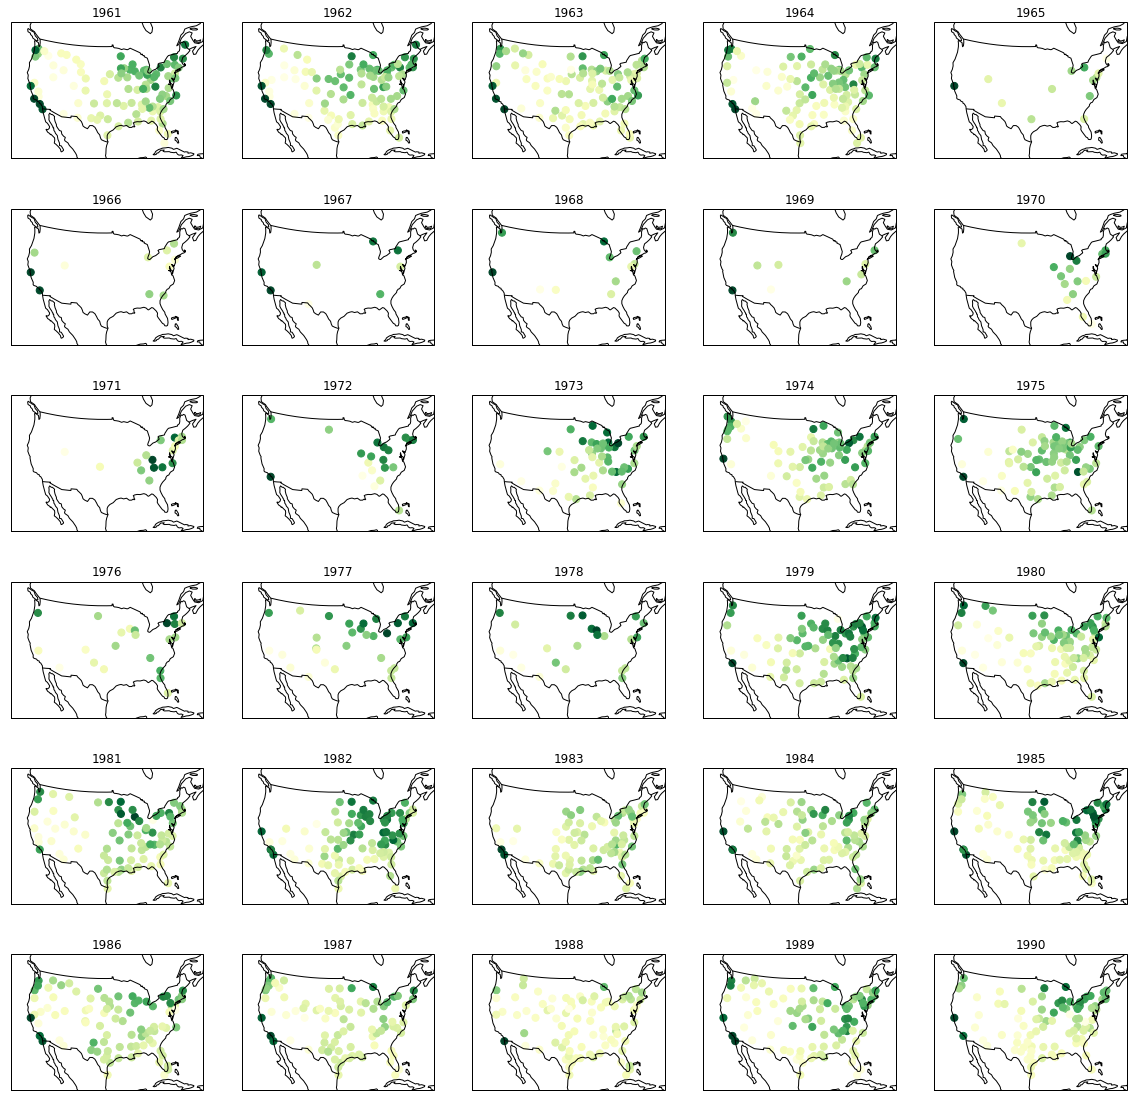

In [335]:
from palettable.colorbrewer.sequential import YlGn_9

years = np.arange(1961, 1991)
extent = [-123, -72, 19, 53]

fig, axs = plt.subplots(6, 5, figsize=(20,20), 
                        subplot_kw={'projection': ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35)})

for ax, year in zip(axs.flatten(), years):
    df_sub = df_earsum[df_earsum.year == str(year)]
    ax.scatter(df_sub.lon.astype(float)*-1, df_sub.lat.astype(float), 
               c=df_sub.ear, cmap=YlGn_9.mpl_colormap,
               transform=ccrs.PlateCarree(), alpha=1, s=50) # what does 'transform' do, and why does it not work when 
                                                            # I use 'AlbersEqualArea'?
    ax.set_extent(extent)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.set(title=year)    

#### average yield for each location

In [336]:
df_sitesum = df_earsum.groupby('site').mean()
df_sitesum = pd.merge(df_sitesum, df_siteyears, on='site')
df_sitesum.head()

,site,ear,years,city,state,lat,lon
0,03103,52.060000,21,FLAGSTAFF,AZ,35.08,111.4
1,03812,72.919091,20,ASHEVILLE,NC,35.26,82.32
2,03813,23.188000,21,MACON,GA,32.42,83.39
3,03820,27.788889,19,AUGUSTA,GA,33.22,81.58
4,03822,31.913125,20,SAVANNAH,GA,32.08,81.12


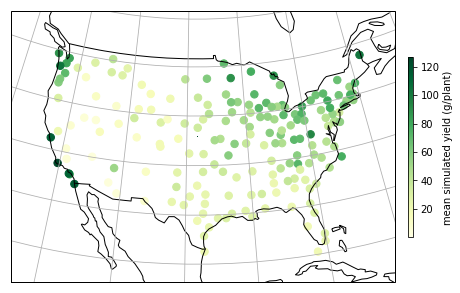

In [337]:
from palettable.colorbrewer.sequential import YlGn_9

fig = plt.figure(figsize=(7,5))
extent = [-123, -72, 19, 53]
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df_sitesum.lon.astype(float)*-1, df_sitesum.lat.astype(float), 
           transform=ccrs.PlateCarree(), 
           s=55, c=df_sitesum.ear, cmap=YlGn_9.mpl_colormap)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()

# weird way to brute force add color bar scale - there might be a better way
lim = np.array([[df_sitesum.ear.min(), df_sitesum.ear.max()]])
im1 = plt.imshow(lim, cmap=YlGn_9.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('mean simulated yield (g/plant)')

plt.show()

#### considering scaling up and comparing with historical yield data

g/plant -> tons/ha <br/>
assume planting density of 10 plants/m2 <br/>
1 ha = 10,000 m2 <br/> 
1 ton = 907185 g <br/>

example case: <br/>
50 g/plant = 50 x 10 g/m2 (10 plants/m2) <br/>
50 x 10000 g/ha (scaling up from m2 to ha) <br/>
(50 x 10000 x 0.86) / 907185 ton/ha <br/>
0.86: conversion from ear to grain biomass

In [51]:
(50*10*10000*0.86)/907185 # ~ 4.7 tons/ha yield

4.739937278504384

### 5. Yield anomalies betetween 1961-1990

In [13]:
df_sitesum.head()

,site,ear,years,city,state,lat,lon
0,03103,52.060000,21,FLAGSTAFF,AZ,35.08,111.4
1,03812,72.919091,20,ASHEVILLE,NC,35.26,82.32
2,03813,23.188000,21,MACON,GA,32.42,83.39
3,03820,27.788889,19,AUGUSTA,GA,33.22,81.58
4,03822,31.913125,20,SAVANNAH,GA,32.08,81.12


In [14]:
df_summary.head()

,ear,site,year,years,city,state,lat,lon
0,53.39,03103,1964,21,FLAGSTAFF,AZ,35.08,111.4
1,50.73,03103,1988,21,FLAGSTAFF,AZ,35.08,111.4
2,87.67,03812,1973,20,ASHEVILLE,NC,35.26,82.32
3,99.10,03812,1975,20,ASHEVILLE,NC,35.26,82.32
4,97.84,03812,1979,20,ASHEVILLE,NC,35.26,82.32


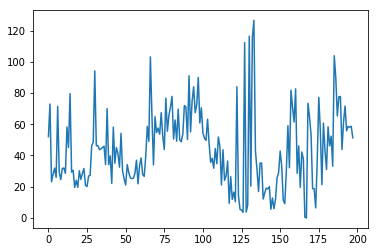

In [15]:
plt.plot(df_sitesum.ear)

### figuring out climate anomalies within 1961-1990

In [16]:
# reading in weather data
df_temp = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/temp_all.csv', index_col= 0)
df_rh = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/rh_all.csv', index_col= 0)
df_precip = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/precip_all.csv', index_col= 0)
df_solrad = pd.read_csv('/home/disk/eos8/ach315/upscale/weadata/backup/solrad_all.csv', index_col= 0)
df_solrad = df_solrad.reindex(df_temp.index)

In [17]:
# listing sites to drop from dataset
df_siteinfo = pd.read_csv("/home/disk/eos8/ach315/upscale/weadata/site_info.csv", index_col=0, dtype=str)
sites_AK = df_siteinfo[df_siteinfo.state == 'AK'].site
sites_HI = df_siteinfo[df_siteinfo.state == 'HI'].site
drop_sites = list(sites_AK.append(sites_HI))
drop_sites.append('41415') # excluding Guam

In [18]:
# reforming dataframes
df_temp = df_temp.drop(drop_sites, axis=1)
df_rh = df_rh.drop(drop_sites, axis=1)
df_precip = df_precip.drop(drop_sites, axis=1)
df_solrad = df_solrad.drop(drop_sites, axis=1)
df_siteinfo = df_siteinfo[df_siteinfo.state != 'PI'] # excluding GUAM
df_siteinfo = df_siteinfo[df_siteinfo.state != 'AK'] # excluding Alaska
df_siteinfo = df_siteinfo[df_siteinfo.state != 'HI'] # excluding Hawaii

In [19]:
# putting together xr.Dataset
timepoints = pd.to_datetime(df_temp.index)
sites = df_temp.columns

ds_wea = xr.Dataset({'temp': (['time', 'site'], df_temp),
                     'precip': (['time', 'site'], df_precip),
                     'rh': (['time', 'site'], df_rh),
                     'solrad': (['time', 'site'], df_solrad)},
                    coords= {'time': timepoints, 
                             'site': sites,
                             'lat': df_siteinfo.lat.astype(float), 
                             'lon': df_siteinfo.lon.astype(float)})

ds_wea

<xarray.Dataset>
Dimensions:  (dim_0: 215, site: 215, time: 197310)
Coordinates:
  * dim_0    (dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
  * time     (time) datetime64[ns] 1961-03-01 1961-03-01T01:00:00 ...
  * site     (site) object '03103' '03812' '03813' '03820' '03822' '03856' ...
    lat      (dim_0) float64 35.08 35.26 32.42 33.22 32.08 34.39 38.22 34.54 ...
    lon      (dim_0) float64 111.4 82.32 83.39 81.58 81.12 86.46 82.33 82.13 ...
Data variables:
    temp     (time, site) float64 nan 12.2 21.7 21.1 18.9 12.8 nan nan 12.2 ...
    precip   (time, site) float64 nan nan 0.0 0.0 0.0 0.0 nan nan nan 0.0 ...
    rh       (time, site) float64 nan 61.14 60.67 67.7 96.25 71.35 nan nan ...
    solrad   (time, site) float64 nan 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...

### precip sum for individual years

In [230]:
# selecting precip data for year 1961
precip_1961 = pd.DataFrame({'precip': ds_wea.sel(time=slice('1961-04-01', '1961-10-31')).precip.sum(dim='time'),
                            'site': ds_wea.site, 'lat': ds_wea.lat, 'lon': ds_wea.lon})

precip_1961.head()


,precip,site,lat,lon
0,73.9,03103,35.08,111.40
1,0.0,03812,35.26,82.32
2,605.2,03813,32.42,83.39
3,650.0,03820,33.22,81.58
4,881.8,03822,32.08,81.12


In [242]:
# sites with weird precip data
print(precip_1961[precip_1961.precip>25000])
print(df_siteinfo[df_siteinfo.site=='24233'])
print(df_siteinfo[df_siteinfo.site=='93037'])
print(df_siteinfo[df_siteinfo.site=='94846'])

       precip   site    lat     lon
176   34284.9  24233  47.27  122.18
180  213978.6  93037  38.49  104.43
210   25724.0  94846  41.47   87.45
      site                    city state    lat     lon
180  24233  SEATTLE                   WA  47.27  122.18
      site                    city state    lat     lon
202  93037  COLORADO SPRINGS          CO  38.49  104.43
      site                    city state    lat    lon
232  94846  CHICAGO                   IL  41.47  87.45


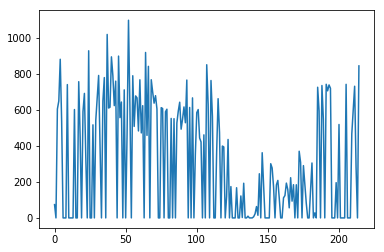

In [185]:
# selecting precip data for year 1961
precip_1961 = pd.DataFrame({'precip': ds_wea.sel(time=slice('1961-04-01', '1961-10-31')).precip.sum(dim='time'),
                            'site': ds_wea.site, 'lat': ds_wea.lat, 'lon': ds_wea.lon})

# excluding unreasonably high precip values
precip_1961 = precip_1961[precip_1961.precip < 25000] # precip units in mm 
                                                      # growing season precip of 25000mm is just impossible in the U.S.

# plotting out results - excluding 3 sites with excess precip 
plt.plot(precip_1961.precip)

### Creating spreadsheet with temp, precip, yield, lat, lon

In [404]:
years = np.arange(1961,1991)
cols = ['year', 'precip', 'temp', 'rh', 'site', 'lat', 'lon']
df_wea = pd.DataFrame(columns = cols)

for i in years:
    df_year = pd.DataFrame({'year': str(i),
                            'precip': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).precip.sum(dim='time'),
                            'temp': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).temp.mean(dim='time'),
                            'rh': ds_wea.sel(time=slice(str(i)+'-04-01', str(i)+'-10-31')).rh.mean(dim='time'),
                            'site': ds_wea.site, 'lat': ds_wea.lat, 'lon': ds_wea.lon})
    df_wea = pd.concat([df_wea, df_year])

df_wea = df_wea.drop(['lat', 'lon'], axis=1)

In [444]:
df_summary = pd.merge(df_earsum, df_wea, how='left', on=['site', 'year'])
df_summary = df_summary[df_summary.rh<100] # there are so many sites with RH > 100, so I'm taking it out for the moment
                                           # 200210JH: need to look into this issue   

In [445]:
def CC(temp, RH):
    Es_TRef = 6.11 # Es at reference temperature = 6.11 (mb)
    TRef    = 273.15 # reference temperature (K)
    Lv      = 2.5e+06 # evaporization latent heat = 2.5*10e6 (J/kg)
    Rv      = 461 # gas constant = 461 (J/K*kg)
    
    Es = Es_TRef*np.exp((Lv/Rv)*(1/TRef-1/(temp+TRef)))
    E = (Es*RH)/100
    VPD = Es-E # units mb
    VPD = VPD/10 # converting mb into kPa (1mb = 0.1kPa)
    
    return(VPD)

In [448]:
vpd = CC(df_summary.temp, df_summary.rh)

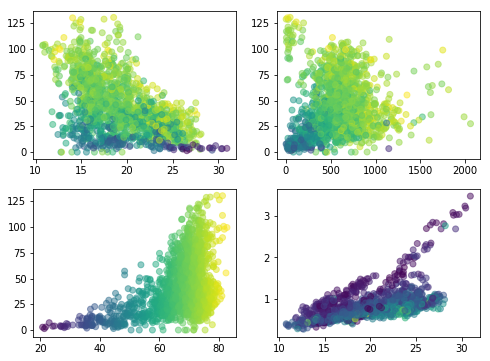

In [450]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
axs = axs.flatten()
axs[0].scatter(df_summary.temp, df_summary.ear, alpha=0.5, c=df_summary.rh)
axs[1].scatter(df_summary.precip, df_summary.ear, alpha=0.5, c=df_summary.rh)
axs[2].scatter(df_summary.rh, df_summary.ear, alpha=0.5, c=df_summary.rh)
axs[3].scatter(df_summary.temp, vpd, alpha=0.5, c=df_summary.precip)

In [474]:
df_precip_summ = pd.DataFrame(df_summary.groupby('site').precip.mean()).reset_index()
df_precip_summ = pd.merge(df_precip_summ, df_siteyears, how='left', on=['site'])
df_precip_summ.head()

,site,precip,years,city,state,lat,lon
0,03812,795.225000,20,ASHEVILLE,NC,35.26,82.32
1,03813,607.466667,21,MACON,GA,32.42,83.39
2,03820,625.388889,19,AUGUSTA,GA,33.22,81.58
3,03822,792.886667,20,SAVANNAH,GA,32.08,81.12
4,03856,757.300000,27,HUNTSVILLE,AL,34.39,86.46


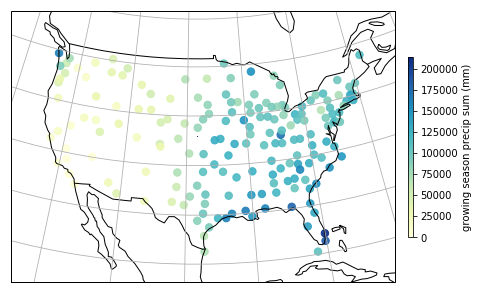

In [475]:
# plotting out precip map

from palettable.colorbrewer.sequential import YlGnBu_8

fig = plt.figure(figsize=(7,5))
extent = [-123, -72, 19, 53]
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))
ax.scatter(df_precip_summ.lon.astype(float)*-1, df_precip_summ.lat.astype(float), 
           transform=ccrs.PlateCarree(), 
           s=55, c=df_precip_summ.precip, alpha=0.9, 
           cmap=YlGnBu_8.mpl_colormap)
ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()

# weird way to brute force add color bar scale - there might be a better way
lim = np.array([[precip_1961.precip.min(), 
                 precip_1961.precip.max()]])
im1 = plt.imshow(lim, cmap=YlGnBu_8.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('growing season precip sum (mm)')

plt.show()

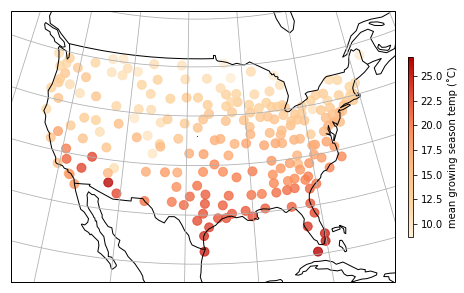

In [476]:
# plotting out data for temperature - 1961-1990

from palettable.colorbrewer.sequential import OrRd_6

extent = [-123, -72, 19, 53]
fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_latitude=39.5, central_longitude=-98.35))

ax.scatter(ds_wea.lon.astype(float)*-1, ds_wea.lat.astype(float), 
           transform=ccrs.PlateCarree(), c= ds_wea.mean('time').temp, s=80,
           cmap=OrRd_6.mpl_colormap, alpha= 0.8)

ax.set_extent(extent)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.gridlines()

lim = np.array([[ds_wea.mean('time').temp.min(), 
                 ds_wea.mean('time').temp.max()]])
im1 = plt.imshow(lim, cmap=OrRd_6.mpl_colormap)
im1.set_visible("False")
cb_ax1 = fig.add_axes([0.92, 0.25, 0.01, 0.5]) 
cb1 = plt.colorbar(im1, cax=cb_ax1)
cb1.ax.set_ylabel('mean growing season temp (˚C)')

plt.show()